In [3]:
import sqlite3
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')

# Load data into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM Transactions", conn)

# Close the connection
conn.close()

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])




In [5]:
# Create the user network
U = nx.DiGraph()
for index, row in df.iterrows():
    timestamp = row['timestamp']
    input_addresses = eval(row['input_addresses_x'])
    output_addresses = eval(row['output_addresses_y'])
    output_amounts = eval(row['output_amounts_y'])

    for i, input_address in enumerate(input_addresses):
        for j, output_address in enumerate(output_addresses):
            if input_address != output_address:  # Avoid self-loops
                if U.has_edge(input_address, output_address):
                    U[input_address][output_address]['value'] += output_amounts[j]
                else:
                    U.add_edge(input_address, output_address, value=output_amounts[j], timestamp=timestamp)

# Debugging: Check the user network
print(f"Number of nodes in user network: {U.number_of_nodes()}")
print(f"Number of edges in user network: {U.number_of_edges()}")


Number of nodes in user network: 525433
Number of edges in user network: 883296


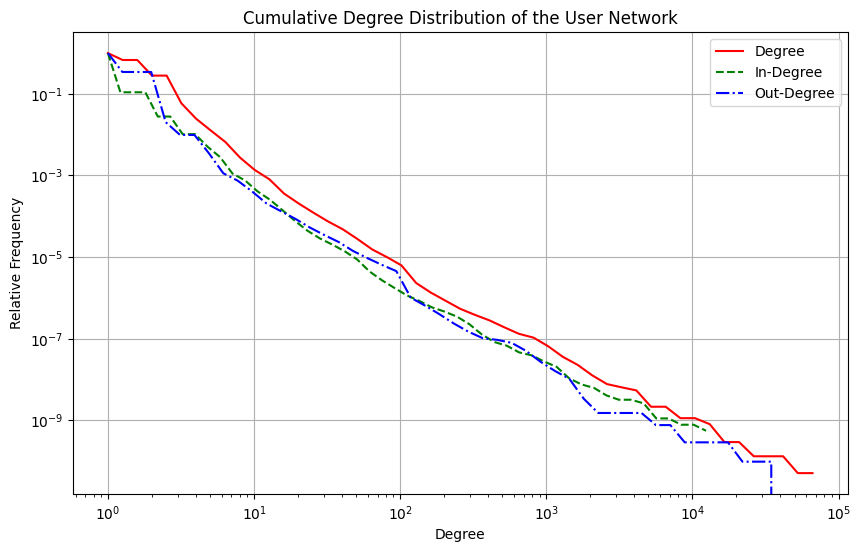

In [6]:
# Calculate degree distributions
degrees = dict(U.degree())
in_degrees = dict(U.in_degree())
out_degrees = dict(U.out_degree())

# Convert to arrays for analysis
degree_values = np.array(list(degrees.values()))
in_degree_values = np.array(list(in_degrees.values()))
out_degree_values = np.array(list(out_degrees.values()))

# Compute histograms
degree_hist, degree_bin_edges = np.histogram(degree_values, bins=np.logspace(np.log10(1), np.log10(max(degree_values)), num=50), density=True)
in_degree_hist, in_degree_bin_edges = np.histogram(in_degree_values, bins=np.logspace(np.log10(1), np.log10(max(in_degree_values)), num=50), density=True)
out_degree_hist, out_degree_bin_edges = np.histogram(out_degree_values, bins=np.logspace(np.log10(1), np.log10(max(out_degree_values)), num=50), density=True)

# Compute cumulative distributions
cumulative_degree = np.cumsum(degree_hist[::-1])[::-1]
cumulative_in_degree = np.cumsum(in_degree_hist[::-1])[::-1]
cumulative_out_degree = np.cumsum(out_degree_hist[::-1])[::-1]

# Normalize cumulative distributions
cumulative_degree /= cumulative_degree[0]
cumulative_in_degree /= cumulative_in_degree[0]
cumulative_out_degree /= cumulative_out_degree[0]

# Plot the cumulative degree distribution
plt.figure(figsize=(10, 6))
plt.plot(degree_bin_edges[:-1], cumulative_degree, 'r-', label='Degree')
plt.plot(in_degree_bin_edges[:-1], cumulative_in_degree, 'g--', label='In-Degree')
plt.plot(out_degree_bin_edges[:-1], cumulative_out_degree, 'b-.', label='Out-Degree')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Relative Frequency')
plt.title('Cumulative Degree Distribution of the User Network')
plt.legend()
plt.grid(True)
plt.show()

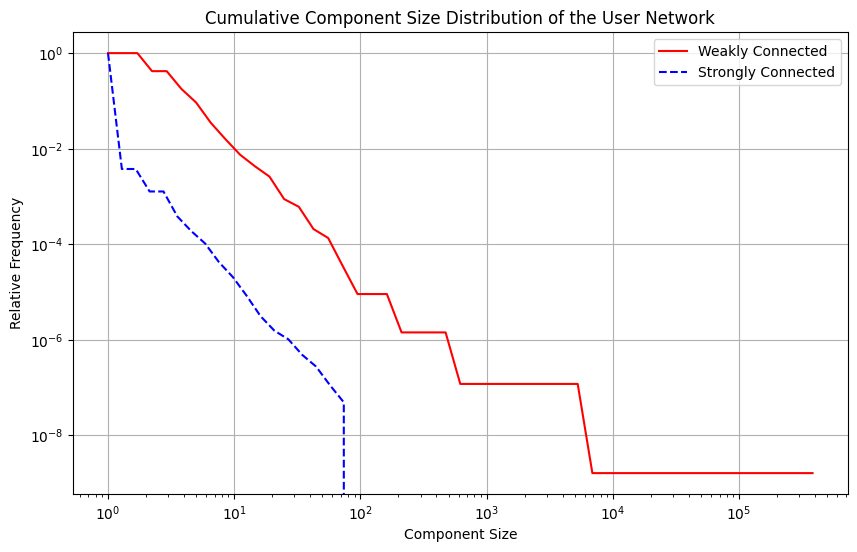

In [8]:
# Identify weakly and strongly connected components
weakly_connected_components = [len(c) for c in nx.weakly_connected_components(U)]
strongly_connected_components = [len(c) for c in nx.strongly_connected_components(U)]

# Compute histograms for component sizes
weakly_hist, weakly_bin_edges = np.histogram(weakly_connected_components, bins=np.logspace(np.log10(1), np.log10(max(weakly_connected_components)), num=50), density=True)
strongly_hist, strongly_bin_edges = np.histogram(strongly_connected_components, bins=np.logspace(np.log10(1), np.log10(max(strongly_connected_components)), num=50), density=True)

# Compute cumulative distributions
cumulative_weakly = np.cumsum(weakly_hist[::-1])[::-1]
cumulative_strongly = np.cumsum(strongly_hist[::-1])[::-1]

# Normalize cumulative distributions
cumulative_weakly /= cumulative_weakly[0]
cumulative_strongly /= cumulative_strongly[0]

# Plot the cumulative component size distribution
plt.figure(figsize=(10, 6))
plt.plot(weakly_bin_edges[:-1], cumulative_weakly, 'r-', label='Weakly Connected')
plt.plot(strongly_bin_edges[:-1], cumulative_strongly, 'b--', label='Strongly Connected')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Component Size')
plt.ylabel('Relative Frequency')
plt.title('Cumulative Component Size Distribution of the User Network')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Identify weakly connected components
weakly_connected_components = sorted(nx.weakly_connected_components(U), key=len, reverse=True)

# Select the largest weakly connected component
largest_weakly_connected_component = weakly_connected_components[0]

# Create a subgraph for the largest weakly connected component
largest_wcc_subgraph = U.subgraph(largest_weakly_connected_component).copy()

# Analyze degree centrality within the largest weakly connected component
degree_centrality = nx.degree_centrality(largest_wcc_subgraph)

# Find the top 10 key nodes with the highest degree centrality
top_10_key_nodes = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]

# Print the top 10 key nodes
print("Top 10 key nodes with the highest degree centrality:")
for node, centrality in top_10_key_nodes:
    print(f"Node: {node}, Degree Centrality: {centrality}")

# Visualize the largest weakly connected component with key nodes highlighted
pos = nx.spring_layout(largest_wcc_subgraph)
plt.figure(figsize=(12, 12))
nx.draw(largest_wcc_subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=8)
nx.draw_networkx_nodes(largest_wcc_subgraph, pos, nodelist=[node for node, centrality in top_10_key_nodes], node_color='red', node_size=300)
plt.title("Largest Weakly Connected Component with Key Nodes Highlighted")
plt.show()

Top 10 key nodes with the highest degree centrality:
Node: c3e74fdd4175525fc3d6201ba0ffaf805cdfe1308ebe5afd6bca6f759293cb0a, Degree Centrality: 0.16731298611597714
Node: b8ea84387ca58a8d6d5ac452800cf5ce8fb480608077ad289d275c67788d1efe, Degree Centrality: 0.08791078989779678
Node: 4a956e1b10b766281a42dede35bb0833edcff0a81148ecc04402986df16c721c, Degree Centrality: 0.04269512207329403
Node: 2aa8bb7b8160a8e49a60a2dcc21c0e8d1362cb5112e7803451f4fb8c23a8bf1f, Degree Centrality: 0.029790087988868758
Node: e02068f2ac0eb8d898a2d019559e77d68a89635a93fa093cd88f2f352055cacd, Degree Centrality: 0.029229521817035208
Node: 5a665d4b7a858ce5f0b2b7aa46ef99e6ab2e97d88aab55a4b9288bd0842df787, Degree Centrality: 0.021253466000660668
Node: 2f8e43d954ffcf951148fcf49f38368e1f6069371baa01be11f42f826546b564, Degree Centrality: 0.01533548884373217
Node: 5a11e358278148d43bc0b98d96e1768dbb5fc3a01267e6728d60b269a5ce6fbe, Degree Centrality: 0.014993143074505251
Node: 04b6c351b381ce42fae12b065e4587d932cbdd6af552885a7